## Download repo


In [0]:
import os
import shutil
import zipfile
import urllib.request

In [0]:
REPO_ZIP_FILE = 'LinearizedNNs-master.zip'
urllib.request.urlretrieve('https://github.com/maxkvant/LinearizedNNs/archive/master.zip', REPO_ZIP_FILE)

REPO_PATH = "LinearizedNNs-master"
if os.path.exists(REPO_PATH):
    shutil.rmtree(REPO_PATH)
    
with zipfile.ZipFile(REPO_ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall('.')
    
assert os.path.exists(REPO_PATH)

## Imports

In [0]:
import sys
sys.path.append(f"{REPO_PATH}/src")

In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.datasets import FashionMNIST

from xgboost import XGBClassifier

from pytorch_impl.estimators import SgdEstimator
from pytorch_impl.nns import warm_up_batch_norm
from pytorch_impl import ClassifierTraining
from pytorch_impl.matrix_exp import matrix_exp, compute_exp_term
from pytorch_impl.nns.utils import to_one_hot

In [0]:
def to_zca(train, test, min_divisor=1e-8, zca_bias=0.0001, return_weights=False):
    origTrainShape = train.shape
    origTestShape = test.shape

    train = np.ascontiguousarray(train, dtype=np.float32).reshape(train.shape[0], -1).astype('float64')
    test = np.ascontiguousarray(test, dtype=np.float32).reshape(test.shape[0], -1).astype('float64')


    nTrain = train.shape[0]

    # Zero mean every feature
    train = train - np.mean(train, axis=1)[:,np.newaxis]
    test = test - np.mean(test, axis=1)[:,np.newaxis]

    # Normalize
    train_norms = np.linalg.norm(train, axis=1)
    test_norms = np.linalg.norm(test, axis=1)

    # Make features unit norm
    train = train/train_norms[:,np.newaxis]
    test = test/test_norms[:,np.newaxis]

    data_means = np.mean(train, axis=1)


    trainCovMat = 1.0/nTrain * train.T.dot(train)

    (E,V) = np.linalg.eig(trainCovMat)

    E += zca_bias
    sqrt_zca_eigs = np.sqrt(E)
    inv_sqrt_zca_eigs = np.diag(np.power(sqrt_zca_eigs, -1))
    global_ZCA = V.dot(inv_sqrt_zca_eigs).dot(V.T)

    train = (train).dot(global_ZCA)
    test = (test).dot(global_ZCA)
    if return_weights:
        return (train.reshape(origTrainShape).astype('float64'), test.reshape(origTestShape).astype('float64')), global_ZCA
    else:
        return (train.reshape(origTrainShape).astype('float64'), test.reshape(origTestShape).astype('float64'))

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self, num_classes, input_channels, num_channels=64, channel_groups=1):
        super(CNN, self).__init__()

        self.prepare = nn.Sequential(
            nn.Conv2d(input_channels, num_channels, kernel_size=3, stride=1, padding=1, bias=False),  # output: 32 x 32 x num_channels
            nn.BatchNorm2d(num_channels),
            nn.ReLU(),
        )

        self.layers = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1, groups=channel_groups, bias=False),  # output: 32 x 32 x num_channels
            nn.BatchNorm2d(num_channels),
            nn.ReLU(),

            nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=2, padding=1, groups=channel_groups, bias=False),  # output: 16 x 16 x num_channels
            nn.BatchNorm2d(num_channels),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(num_channels, num_classes, bias=False)

    def forward(self, x):
        x = self.prepare(x)
        x = self.layers(x)
        x_avg = F.adaptive_avg_pool2d(x, (1, 1))
        x_avg = x_avg.view(x_avg.size(0), -1)

        return self.classifier(x_avg)

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Myrtle10(nn.Module):
    def __init__(self, num_classes=10, input_channels=3, num_channels=256):
        super(Myrtle10, self).__init__()

        
        num_filters = num_channels

        self.layers = nn.Sequential(
            nn.Conv2d(3, num_filters, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(),
            
            nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(),

            nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(),

            nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(),

            nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(),

            nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(),

            nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(),

            nn.AvgPool2d(kernel_size=8, stride=8),
            Flatten()
        )
        self.classifier =  nn.Linear(num_filters, num_classes, bias=False)
      
    def readout(self, x):
        return self.layers(x)

    def forward(self, x):
        x = self.readout(x)
        return self.classifier(x)

## Cifar10

In [39]:
torch.manual_seed(0)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

cifar10_stats = {
    "mean" : (0.4914, 0.4822, 0.4465),
    "std"  : (0.24705882352941178, 0.24352941176470588, 0.2615686274509804),
}

transform_train = transforms.Compose([
    transforms.Lambda(lambda x: np.asarray(x)),
    transforms.Lambda(lambda x: np.pad(x, [(4, 4), (4, 4), (0, 0)], mode='reflect')),
    transforms.Lambda(lambda x: Image.fromarray(x)),
    transforms.RandomCrop(32),
    
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_stats['mean'], cifar10_stats['std']),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_stats['mean'], cifar10_stats['std']),
])

train_loader = torch.utils.data.DataLoader(
                  datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train), # change back to 
               batch_size=128, shuffle=True, pin_memory=True)

test_loader  = torch.utils.data.DataLoader(
                  datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test),
               batch_size=128, shuffle=True, pin_memory=True)

device

Files already downloaded and verified
Files already downloaded and verified


device(type='cuda', index=0)

epoch 0/20, 0s since start


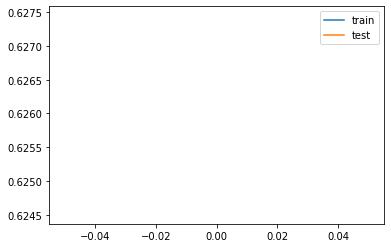

epoch 1/20, 68s since start


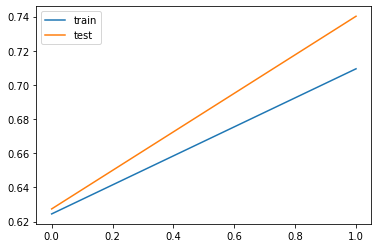

epoch 2/20, 136s since start


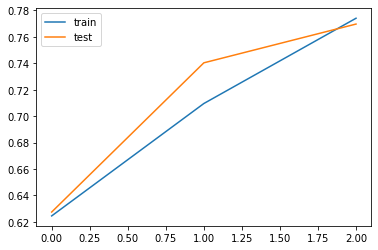

epoch 3/20, 204s since start


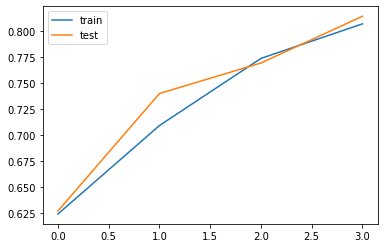

epoch 4/20, 272s since start


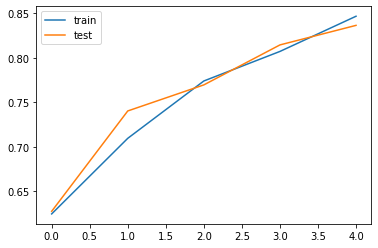

epoch 5/20, 339s since start


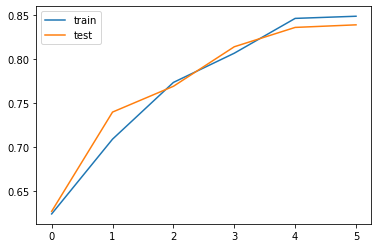

epoch 6/20, 407s since start


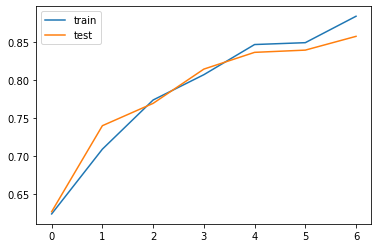

epoch 7/20, 475s since start


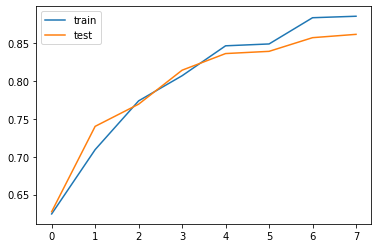

epoch 8/20, 543s since start


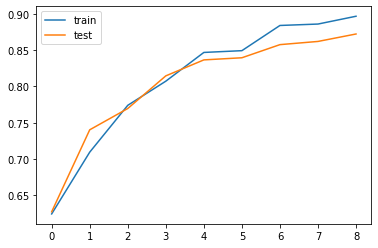

epoch 9/20, 611s since start


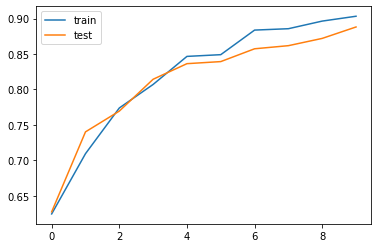

epoch 10/20, 679s since start


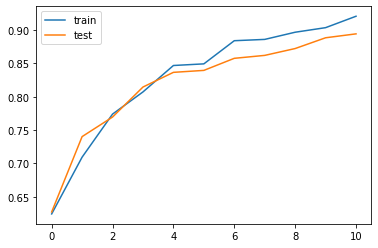

epoch 11/20, 747s since start


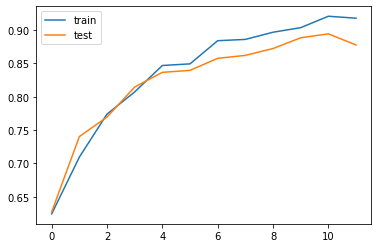

epoch 12/20, 814s since start


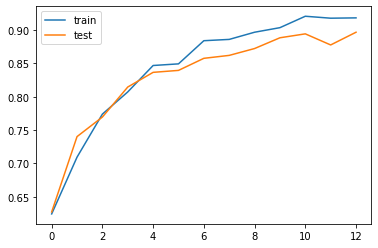

epoch 13/20, 882s since start


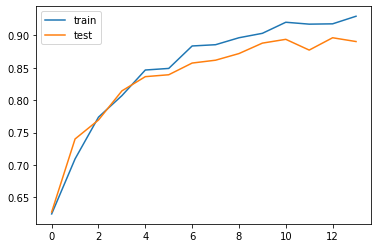

epoch 14/20, 950s since start


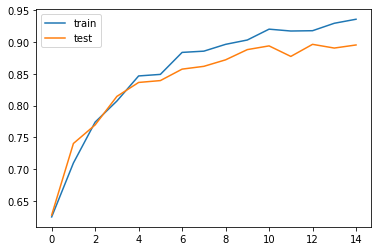

epoch 15/20, 1017s since start


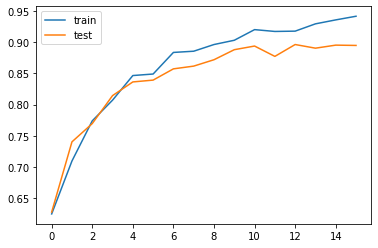

epoch 16/20, 1085s since start


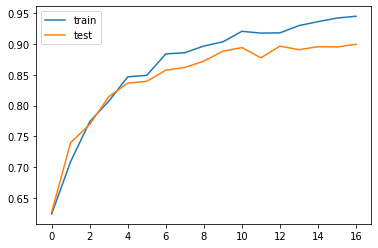

epoch 17/20, 1153s since start


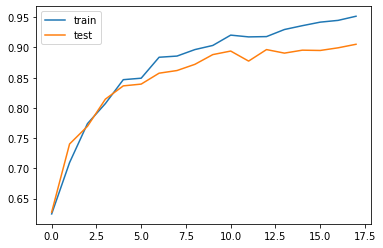

epoch 18/20, 1221s since start


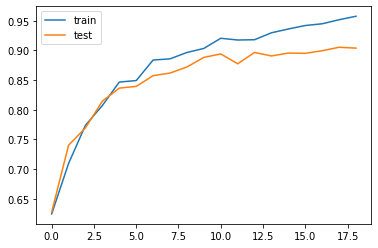

epoch 19/20, 1288s since start


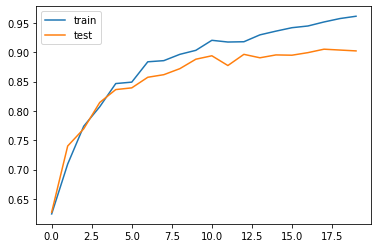

training took 1356s
test_accuracy 0.902


In [40]:
model = Myrtle10().to(device)

learning_rate = 0.03

estimator = SgdEstimator(model, nn.CrossEntropyLoss(), learning_rate)
training  = ClassifierTraining(estimator, device)

training.train(train_loader, test_loader, num_epochs=20, learning_rate=learning_rate)

In [41]:
ClassifierTraining(estimator, device).get_accuracy(test_loader)

0.9036787974683544